In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# task 1.1 ------------------------------------------------------
def construct_adj_matrix(N,alpha,beta):
  adj_mat = np.zeros((N,N))
  neurons = np.zeros((N,2))

  neurons = np.zeros((N,2))
  neurons[0,:] = np.random.rand(2)
  count = 1
  while count < N:
      # candidate
      new_neuron = np.random.rand(2)

      # distance and probability
      distance = np.sqrt(((neurons - new_neuron) ** 2).sum(axis=1))
      prob = beta * np.exp(-alpha * distance)

      edges = np.random.rand(N) < prob
      edges[count:] = False

      # add neuron to matrix if >= 1 edges were created
      if edges.sum() != 0:
          neurons[count,:] = new_neuron
          adj_mat[edges,count] = 1
          adj_mat[count,:] = edges

          count += 1
  return neurons, adj_mat


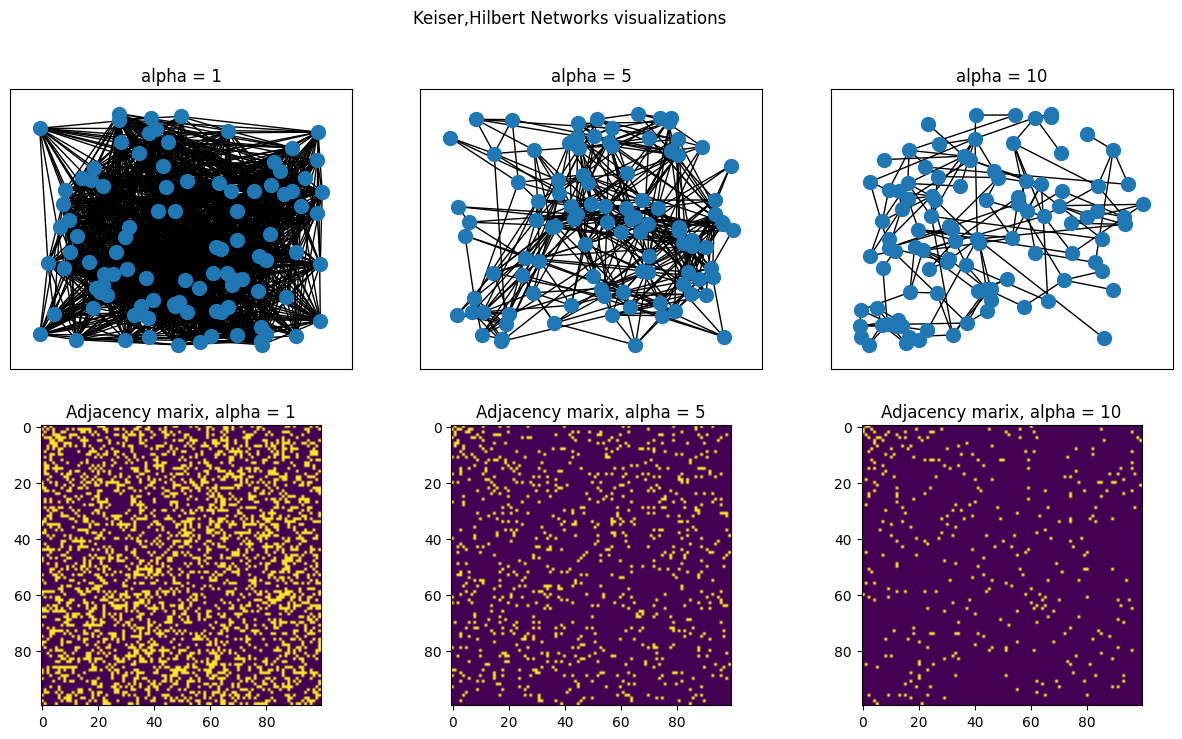

In [ ]:
# task 1.2-----------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
N,beta = 100, 0.5
for i, alpha in enumerate([1,5,10]):

    positions, A = construct_adj_matrix(N,alpha,beta)
    graph = nx.Graph(A)

    pos = dict(zip(np.arange(N), positions))
    G = nx.from_numpy_array(A, create_using=nx.Graph)

    nx.draw_networkx(G, with_labels=False, pos = pos, ax= axes[0,i], node_size=100)
    axes[0,i].set_title(f'alpha = {alpha}')

    # plot adjacency matrix
    axes[1,i].imshow(A, cmap="viridis")
    axes[1,i].set_title(f'Adjacency marix, alpha = {alpha}')

plt.suptitle('Keiser,Hilbert Networks visualizations ')
plt.show()


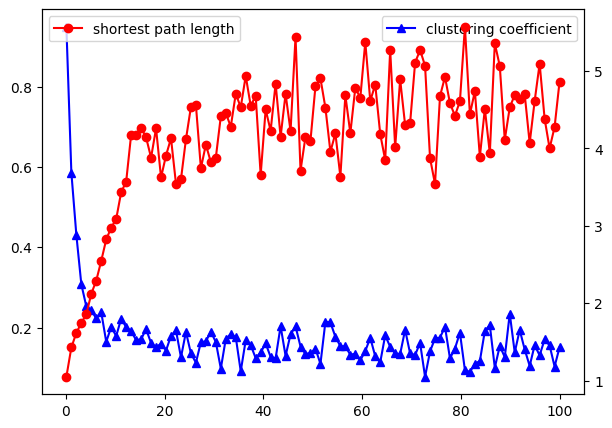

In [ ]:
#task 1.3 -------------------------------------------------------------
N,beta = 100, 1
alphas = np.linspace(0.1, N, 100)
cl_coef,sh_path = [],[]

for alpha in alphas:
    _, A = construct_adj_matrix(N,alpha,beta)
    G = nx.from_numpy_array(A, create_using=nx.Graph)
    cl_coef.append(nx.average_clustering(G))
    sh_path.append(nx.average_shortest_path_length(G))


fig, axes = plt.subplots(figsize=(7, 5))
cl_coef = np.array(cl_coef)
axes.plot(alphas, cl_coef, marker = '^',color = 'b', label="clustering coefficient")
axes.legend()

ax2 = axes.twinx()
ax2.plot(alphas, sh_path, marker = 'o', color="r", label="shortest path length")


plt.legend()
plt.show()


In [ ]:
# task 2.1---------------------------------------------------------------
def improved_matrix(N,alpha, ro = 0.1):
    neurons = np.random.rand(N,2)
    adj_mat = np.zeros((N,N))

    # precompute distances (static)
    distances = np.sqrt(((neurons[:,None,:] - neurons[None,:,:])**2).sum(axis=-1))

    prob = np.exp(-alpha * distances)
    np.fill_diagonal(prob, 0)
    prob = prob / prob.sum()

    # in the beginning we have no edges
    edges_count = 0
    density = 0

    while density < ro :
        # add one edge acccording to the prob
        edge_idx = np.random.choice(N*N, 1, p=prob.flatten())
        x,y = edge_idx // N, edge_idx % N

        if adj_mat[x,y] == 0:
            edges_count += 1

        adj_mat[x,y] += 1

        # recompute density
        density = edges_count / (N * (N-1))

    return neurons, adj_mat

In [ ]:
# (optional task) measuring the speed
import time

start = time.perf_counter()
improved_matrix(100,5)
end = time.perf_counter()

time_N_100 = end - start
print(f'Time for N = 100: {time_N_100} seconds')

start = time.perf_counter()
improved_matrix(1000,5)
end = time.perf_counter()

time_N_1000 = end - start
print(f'Time for N = 1000: {time_N_1000} seconds')


Time for N = 100: 0.19345925699997224 seconds
Time for N = 1000: 1575.749423916 seconds


In [ ]:
# faster algorithm
def improved_matrix_fast(N,alpha,ro=0.1):
  neurons = np.random.rand(N,2)
  adj_mat = np.zeros((N,N))

  # distances
  distances = np.sqrt(((neurons[:,None,:] - neurons[None,:,:])**2).sum(axis=-1))

  prob = np.exp(-alpha * distances)
  np.fill_diagonal(prob, 0)
  prob = prob / prob.sum()
  prob_flat = prob.flatten()

  # Sample edges WITH replacement (allows multiple edges)
  max_edges = int(N * (N-1) * ro)
  edge_indices = np.random.choice(
      N * N,
      size=max_edges,
      p=prob_flat,
      replace = True
  )
  for edge_idx in edge_indices:
    x, y = edge_idx // N, edge_idx % N
    adj_mat[x, y] += 1

  edges_count = (adj_mat != 0).sum()
  density = edges_count / (N * (N-1))

  # expected number of target edges
  num_target_edges = max_edges * prob_flat

  while density < ro :

    # add one edge acccording to the prob
    edge_idx = np.random.choice(N*N, 1, p=prob.flatten())

    # add only <= edges as expected value
    if adj_mat[edge_idx // N, edge_idx % N] >= num_target_edges[edge_idx]:
      prob[edge_idx // N, edge_idx % N] = 0
      prob = prob / prob.sum()
      edges_count += 1

    x,y = edge_idx // N, edge_idx % N
    if adj_mat[x,y] == 0:
        edges_count += 1

    adj_mat[x,y] += 1

    # recompute density
    density = edges_count / (N * (N-1))
  return neurons, adj_mat


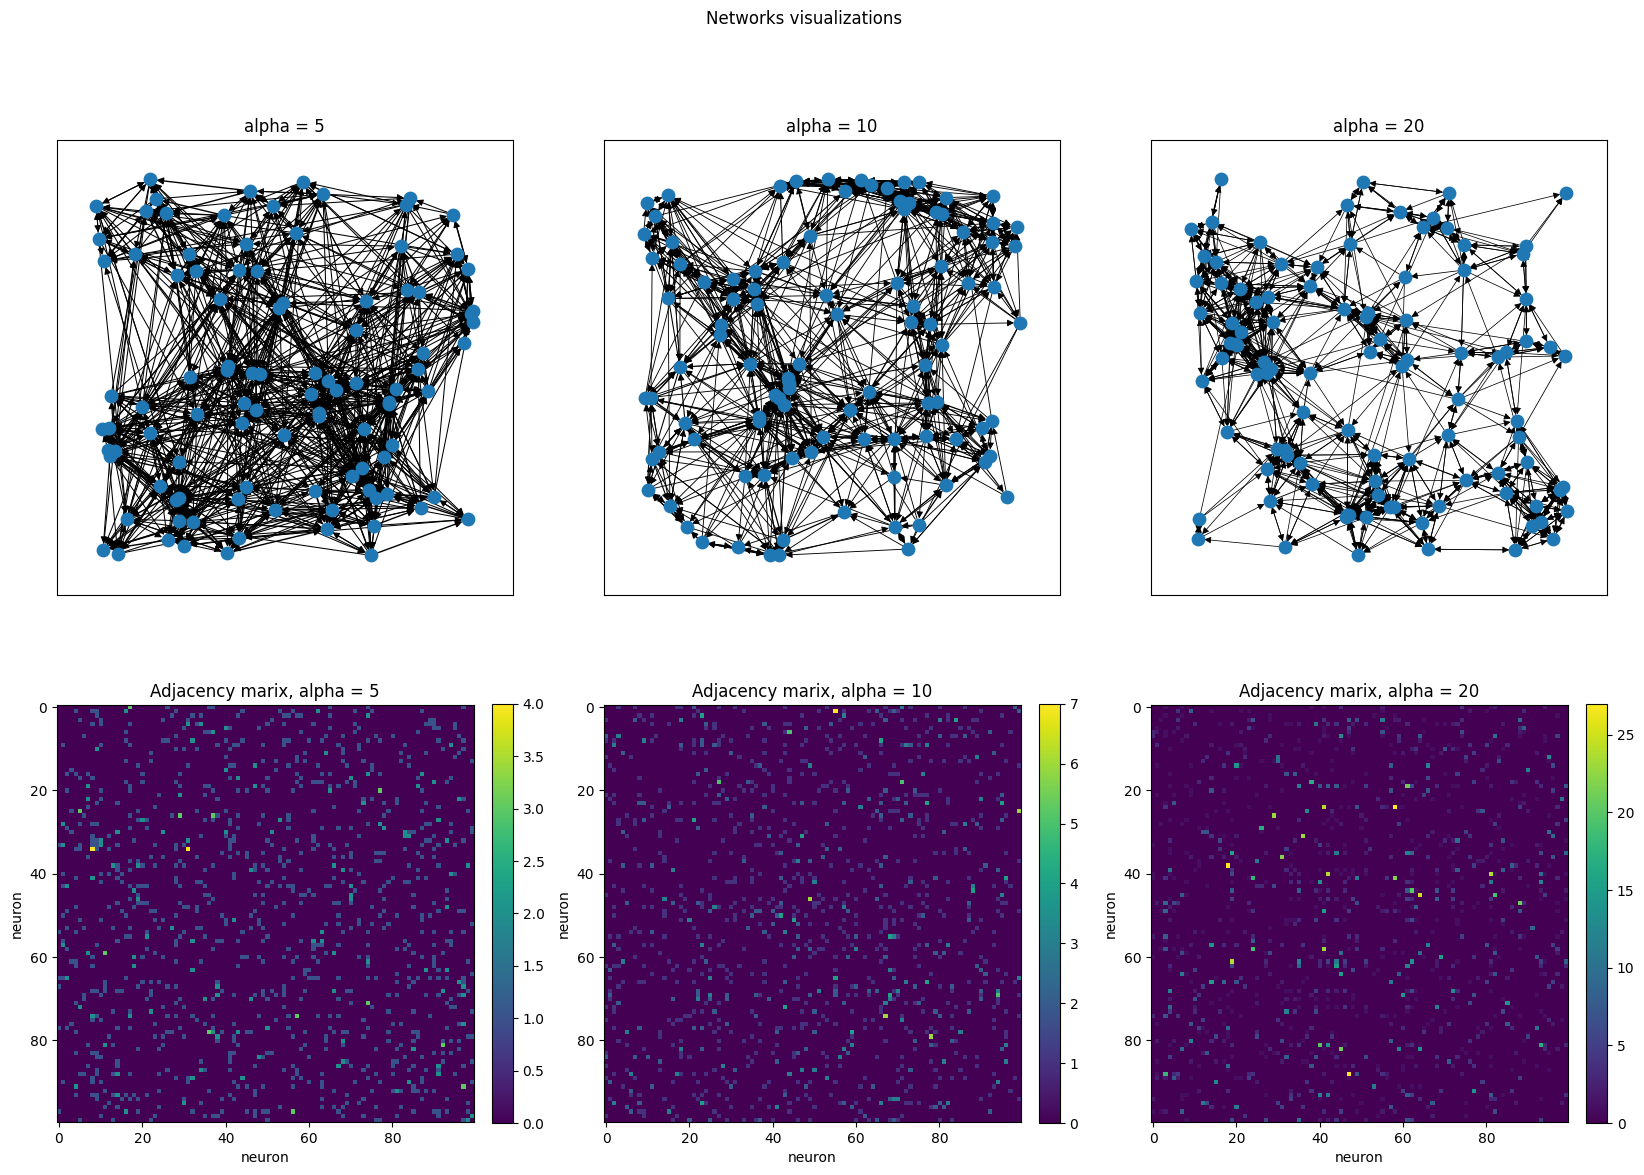

In [ ]:
# task 2.2-----------------------------------------------------------------------------
N = 100
fig, axes = plt.subplots(2, 3, figsize=(20, 13))

for i, alpha in enumerate([5,10,20]):

    positions,A = improved_matrix(N,alpha)

    pos = dict(zip(np.arange(N), positions))
    G = nx.from_numpy_array(A, create_using=nx.DiGraph)
    weights_list = np.array([G[u][v]["weight"] for u, v in G.edges()])
    weights_list = 0.5 + weights_list / weights_list.max()

    nx.draw_networkx(G, with_labels=False, width=weights_list, pos = pos, ax= axes[0,i], node_size=80)
    axes[0,i].set_title(f'alpha = {alpha}')

    # plot adjacency matrix
    im = axes[1,i].imshow(A, cmap="viridis")
    axes[1,i].set_title(f'Adjacency marix, alpha = {alpha}')
    fig.colorbar(im, ax=axes[1, i], fraction=0.046, pad=0.04)
    axes[1,i].set_xlabel('neuron')
    axes[1,i].set_ylabel('neuron')

plt.suptitle('Networks visualizations ')

plt.show()

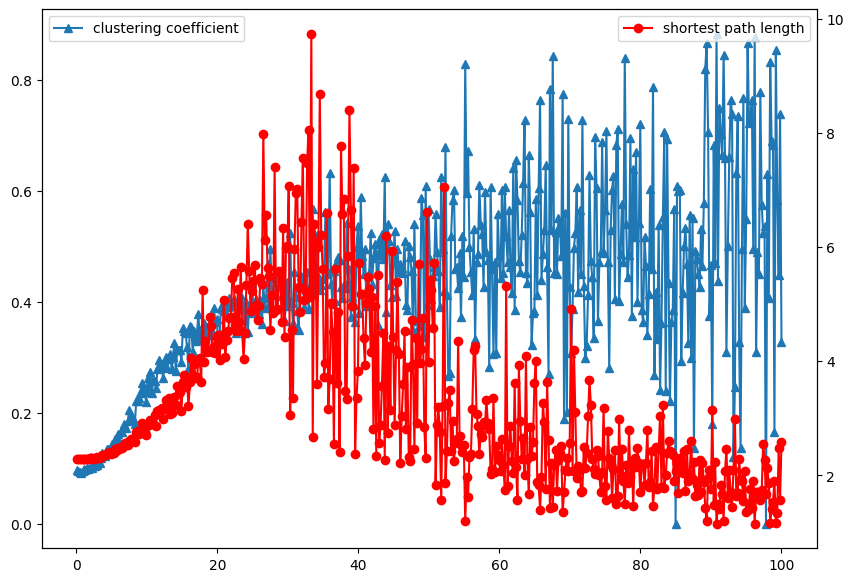

In [ ]:
# task 2.3-----------------------------------------------------------------------------
N = 100
alphas = np.linspace(0.1, 100, 500)
cl_coef,sh_path = [],[]
for alpha in alphas:
    # using improved algorithm
    _,A = improved_matrix_fast(N,alpha)
    G = nx.from_numpy_array(A, create_using=nx.DiGraph)

    # compute statistics only on giant component
    lcc = max(nx.strongly_connected_components(G), key=len)
    G_lcc = G.subgraph(lcc)
    cl_coef.append(nx.average_clustering(G_lcc))
    sh_path.append(nx.average_shortest_path_length(G_lcc))


fig, axes = plt.subplots(figsize=(10, 7))
cl_coef = np.array(cl_coef)
axes.plot(alphas, cl_coef, marker = '^',label="clustering coefficient")

ax2 = axes.twinx()
ax2.plot(alphas, sh_path, marker = 'o', color="r", label="shortest path length")

ax2.legend()
axes.legend()
plt.show()

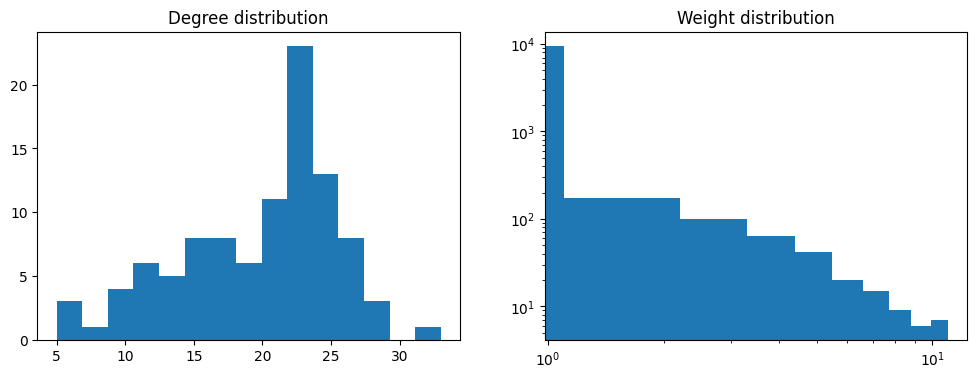

In [ ]:
# task 2.4 ---------------------------------------------------------------------------
N=100
alpha=15
_,A = improved_matrix(N,alpha)
G = nx.from_numpy_array(A, create_using=nx.DiGraph)

degree_dist = dict(nx.degree(G))
weight_dist = A.flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(degree_dist.values(), bins = 15)
axes[1].hist(weight_dist,bins = 10)
axes[0].set_title('Degree distribution')

axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_title('Weight distribution')

plt.show()

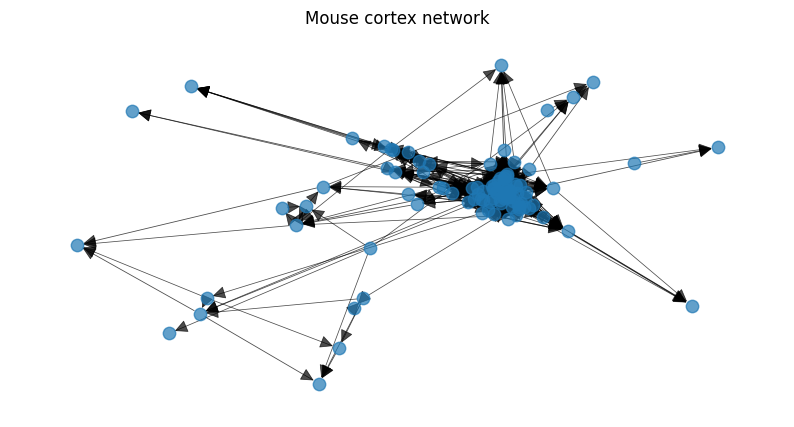

In [ ]:
# task 3.1 --------------------------------------------------
A = np.load('mouse_V1_adjacency_matrix.npy')
G = nx.from_numpy_array(A,create_using=nx.DiGraph)

fig, axes = plt.subplots(figsize=(10, 5))
pos = nx.spring_layout(G)

# nx.draw_networkx(G,pos, with_labels=False, ax= axes, node_size=100)
axes.set_title(f'Mouse cortex network')

edges = G.edges()
weights = np.array([G[u][v].get('weight', 0) for u,v in edges])

weights = 0.5 + weights / weights.max()

nx.draw(
    G,
    #pos,
    with_labels=False,
    #edge_color=weights,
    edge_cmap=plt.cm.viridis,
    arrowsize=20,
    width = weights,
    node_size=80,
    alpha = 0.7

)

plt.show()

In [ ]:
# task 3.2 ---------------------------------------------

mouse_density = (A != 0).sum() / (N * (N-1))
print(f'Mouse cortex density: {mouse_density}')


Mouse cortex density: 0.07696969696969697


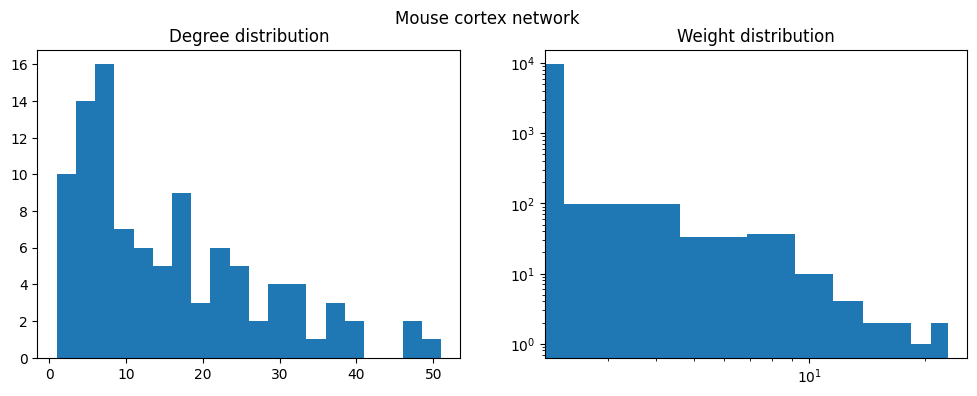

In [ ]:
# visualization of mouse cortex network
degree_dist = dict(nx.degree(G))
weight_dist = A.flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(degree_dist.values(), bins = 20)
axes[1].hist(weight_dist)
axes[0].set_title('Degree distribution')

axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_title('Weight distribution')

plt.suptitle('Mouse cortex network')
plt.show()

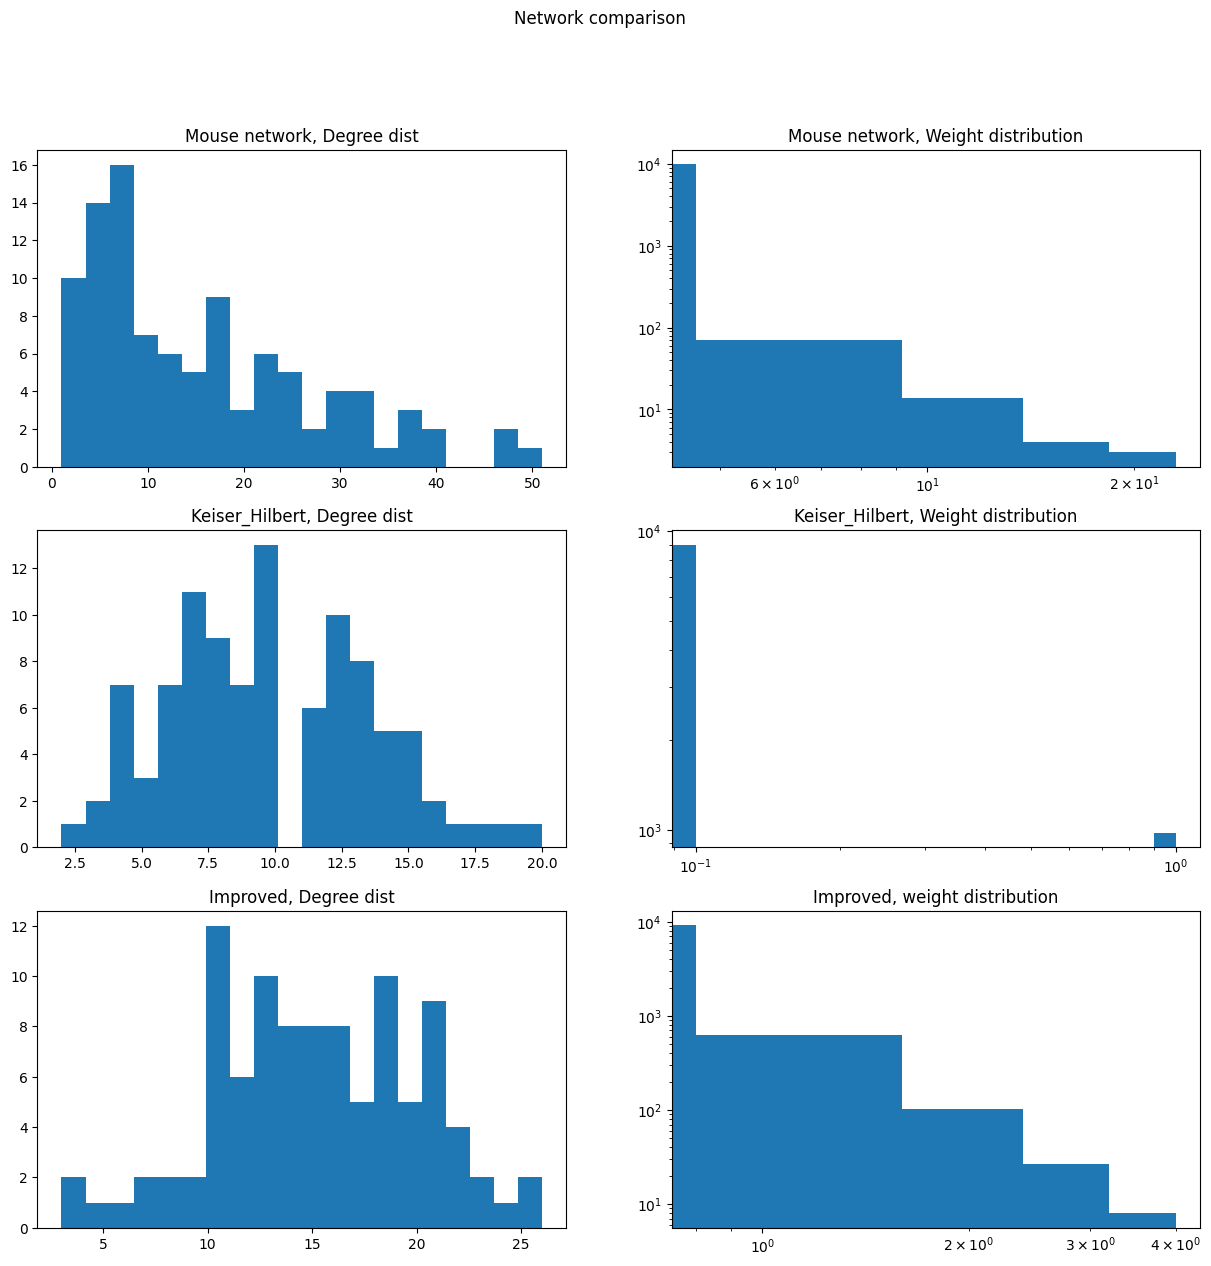

In [ ]:
# comparison of the networks distributions
A = np.load('mouse_V1_adjacency_matrix.npy')
G = nx.from_numpy_array(A,create_using=nx.DiGraph)

# mouse network
degree_dist = dict(nx.degree(G))
weight_dist = A.flatten()

fig, axes = plt.subplots(3, 2, figsize=(15, 14))

axes[0,0].hist(degree_dist.values(), bins = 20)
axes[0,1].hist(weight_dist, bins = 5)
axes[0,0].set_title('Mouse network, Degree dist')

axes[0,1].set_xscale("log")
axes[0,1].set_yscale("log")
axes[0,1].set_title('Mouse network, Weight distribution')

# keiser network
# best alpha = 4.13636364

N,beta,alpha = 100,0.5,4.13636364
_, A_k = construct_adj_matrix(N,alpha,beta)
G_k = nx.from_numpy_array(A_k, create_using=nx.Graph)

degree_dist = dict(nx.degree(G_k))
weight_dist = A_k.flatten()

axes[1,0].hist(degree_dist.values(), bins = 20)
axes[1,1].hist(weight_dist)
axes[1,0].set_title('Keiser_Hilbert, Degree dist')

axes[1,1].set_xscale("log")
axes[1,1].set_yscale("log")
axes[1,1].set_title('Keiser_Hilbert, Weight distribution')

# improved algorithm
# best alpha = 10

N,alpha = 100,10
_,A_i = improved_matrix(N,alpha, ro = mouse_density)
G_i = nx.from_numpy_array(A_i, create_using=nx.DiGraph)
degree_dist = dict(nx.degree(G_i))
weight_dist = A_i.flatten()

axes[2,0].hist(degree_dist.values(), bins = 20)
axes[2,1].hist(weight_dist, bins = 5)
axes[2,0].set_title('Improved, Degree dist')

axes[2,1].set_xscale("log")
axes[2,1].set_yscale("log")
axes[2,1].set_title('Improved, weight distribution')

plt.suptitle('Network comparison')
plt.show()

In [ ]:
# comparison of statistics
networks = [G, G_k, G_i]
names = ['monkey', 'keiser', 'improved']
rows = []

for net,name in zip(networks, names):
  cl = nx.average_clustering(net)
  if isinstance(net, nx.DiGraph):
    lcc = max(nx.strongly_connected_components(net), key=len)
    G_lcc = net.subgraph(lcc)
  else:
    lcc = max(nx.connected_components(net), key=len)
    G_lcc = net.subgraph(lcc)
  sh = nx.average_shortest_path_length(G_lcc)
  rows.append({
        'network': name,
        'clustering_coefficient': cl,
        'avg_shortest_path_length': sh
    })

df = pd.DataFrame(rows)
df


,network,clustering_coefficient,avg_shortest_path_length
0,monkey,0.227850,2.508281
1,keiser,0.145286,2.287879
2,improved,0.235162,2.838485


In [ ]:
# task 3.4 -----------------------------------------------------------------------------
def improved_matrix_pref_fast(N, alpha, gamma=0.2, ro=0.01, eps=1e-6):
    neurons = np.random.rand(N, 2)
    adj_mat = np.zeros((N, N))

    distances = np.sqrt(((neurons[:, None, :] - neurons[None, :, :])**2).sum(axis=-1))
    dist_term = distances**(-alpha)
    np.fill_diagonal(dist_term, 0)

    degree = np.zeros(N) + eps
    edges_count = 0
    target_edges = int(ro * N * (N - 1))

    print(target_edges)
    while edges_count < target_edges:
        pref = (np.outer(degree, degree))**gamma
        prob = pref * dist_term
        prob_sum = prob.sum()

        if prob_sum == 0:
            break

        prob /= prob_sum
        idx = np.random.choice(N*N, p=prob.ravel())
        x, y = divmod(idx, N)

        if adj_mat[x, y] == 0:
            edges_count += 1

        adj_mat[x, y] += 1
        degree[x] += 1
        degree[y] += 1
        print(edges_count)
    return neurons, adj_mat

In [ ]:
N,alpha = 100,3
_,A = improved_matrix_pref_fast(N,alpha, ro = mouse_density)

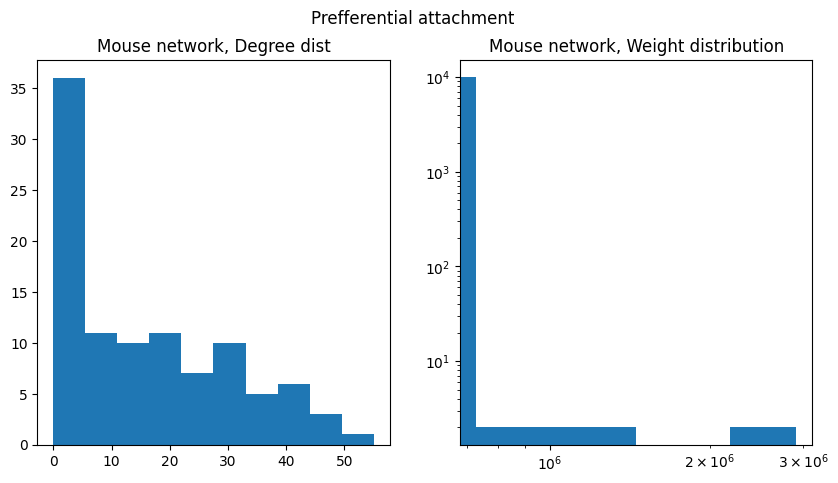

In [ ]:
G = nx.from_numpy_array(A, create_using=nx.DiGraph)
degree_dist = dict(nx.degree(G))
weight_dist = A.flatten()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].hist(degree_dist.values())
axes[1].hist(weight_dist,bins = 4)
axes[0].set_title('Mouse network, Degree dist')

axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_title('Mouse network, Weight distribution')
plt.suptitle('Prefferential attachment')
plt.show()

In [ ]:
cl = nx.average_clustering(G)
if isinstance(G, nx.DiGraph):
  lcc = max(nx.strongly_connected_components(G), key=len)
  G_lcc = G.subgraph(lcc)
else:
  lcc = max(nx.connected_components(G), key=len)
  G_lcc = G.subgraph(lcc)
sh = nx.average_shortest_path_length(G_lcc)

In [ ]:
print('Prefferential attachment: ')
print(f'average shortest_path = {sh}')
print(f'clustering coefficient = {cl}')

average shortest_path = 2.155734406438632
clustering coefficient = 0.16172988158021584
